In [4]:
import sys
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

sys.path.append(os.path.abspath('..'))
from preprocessing import shroom_dealer

To determine association between attributes and edibility we used Pearson's chi-squared test on the frequency of attribute values and then ordered the attributes in descending order of the chi-squared statistic. The chi-squared test works by comparing the observed data to expected data (the null hypothesis which is an even distribution across each row and column) with the following equation,

$$
    \chi^2 = \sum^n_{i=1} \frac{ (O_i - E_i)^2 }{ E_i }
$$

where O is the observed data point and E is the expected data point.




With the following functions we can get a contingency table of the expected and observed values of any two attributes:

In [10]:
def observed_data(attr1, attr2):
    df = shroom_dealer.get_data_frame()

    labels1 = shroom_dealer.get_attribute_dictionary()[attr1]
    labels2 = shroom_dealer.get_attribute_dictionary()[attr2]

    data = []

    for a in df[attr1].cat.categories:
        column = df[attr2][df[attr1] == a].value_counts()
        data.append(column)

    observed = pd.concat(data, axis=1)
    observed.columns = [labels1[a] for a in df[attr1].cat.categories]

    return observed


def expected_data(observed):
    expected = np.zeros(observed.shape)

    total = observed.sum().sum()
    for j in [0, 1]:
        for i, col_total in enumerate(observed.sum()):
            row_total = observed.sum(axis=1)[j]
            expected[j][i] = row_total*col_total/total

    return pd.DataFrame(expected, index=observed.index,
                        columns=observed.columns)

In [11]:
o = observed_data('odor', 'poisonous')
o

,almond,creosote,foul,anise,musty,none,pungent,spicy,fishy
e,400,0,0,400,0,3408,0,0,0
p,0,192,2160,0,36,120,256,576,576


In [12]:
expected_data(o)

,almond,creosote,foul,anise,musty,none,pungent,spicy,fishy
e,207.188577,99.450517,1118.818316,207.188577,18.646972,1827.40325,132.600689,298.351551,298.351551
p,192.811423,92.549483,1041.181684,192.811423,17.353028,1700.59675,123.399311,277.648449,277.648449


Using these two tables for each attribute we can collect the chi-squared test statistic for each, and then sort them in descending order to rank the attributes by association with being poisonous or edible.

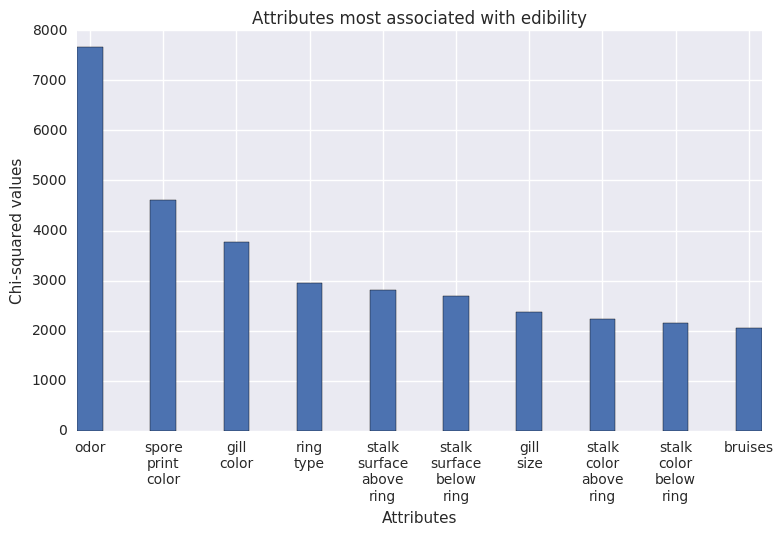

In [14]:
cat_names = shroom_dealer.get_attribute_dictionary().keys()

chisqrs = []
for cat in cat_names:
    if cat != 'poisonous':
        observed = observed_data(cat, 'poisonous')
        expected = expected_data(observed)
        chisqr = (((observed-expected)**2)/expected).sum().sum()
        chisqrs.append((chisqr, cat))

chisqrs = sorted(chisqrs)[::-1]
chisqrs = chisqrs[:10]
values = [d[0] for d in chisqrs]
labels = [d[1].replace("-", "\n") for d in chisqrs]

index = np.arange(len(chisqrs))
bar_width = .35
opacity=0.4

plt.title("Attributes most associated with edibility")
plt.bar(index, values, bar_width, align='center')
plt.xticks(index, labels)
plt.ylabel("Chi-squared values")
plt.xlabel("Attributes")
plt.autoscale()
plt.tight_layout()
plt.show()

As we can see from the plot, odor is the most associated attribute with edibility, followed by spore print color and gill color. These rankings seem to agree heavily with our comparative barcharts.

While this use of the chi-squared test statistic may not be the traditional use of finding the p-value and accepting or rejecting the null hypothesis to determine independence, it still provided us with a metric to rank the attributes by their association of edibility.